In [2]:
import sys
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from skimage.transform import resize
from random import randint
from IPython import embed

from keras.models import load_model

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
THIS_DIR = os.path.abspath("./")
DATA_DIR = os.path.join(ROOT_DIR, "data")
LOGS_DIR = os.path.join(ROOT_DIR, "mask_rcnn_example", "logs")
MASK_CNN_DIR = os.path.join(ROOT_DIR, "Mask_RCNN")
MCRNN_WEIGHTS = os.path.join(THIS_DIR, "models", "mrcnn")
UNET_WEIGHTS = os.path.join(THIS_DIR, "models", "unet")

sys.path.append(MASK_CNN_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from unet.unet import mean_iou
from data.extractor_id import extraction
from mask_rcnn_example import nucleus

/Users/kendall/.local/share/virtualenvs/nuclei-gOr3xsxz/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Look at some sample images and their masks

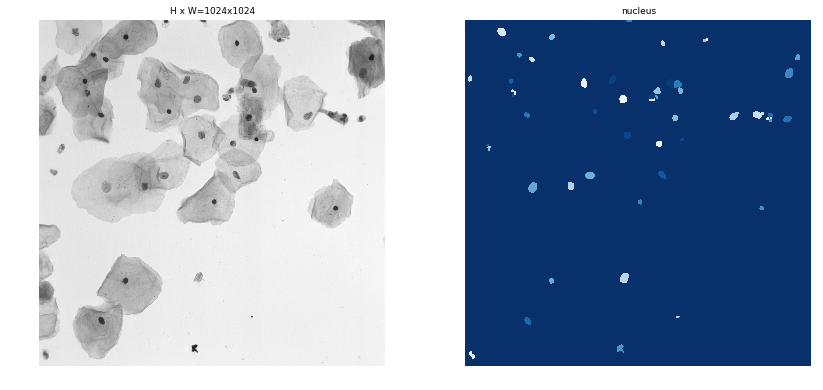

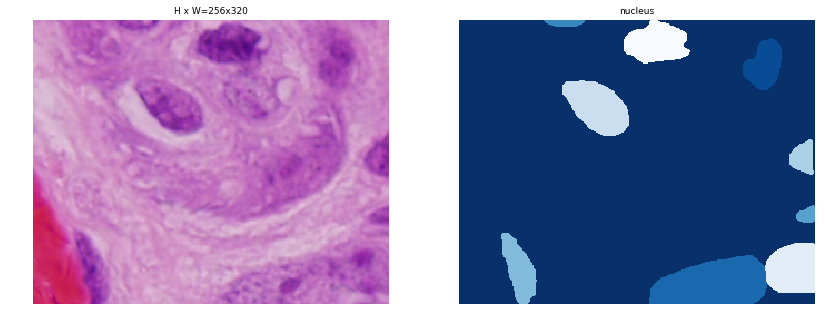

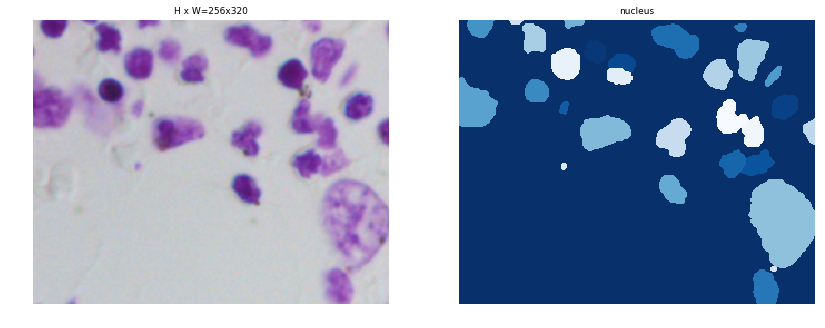

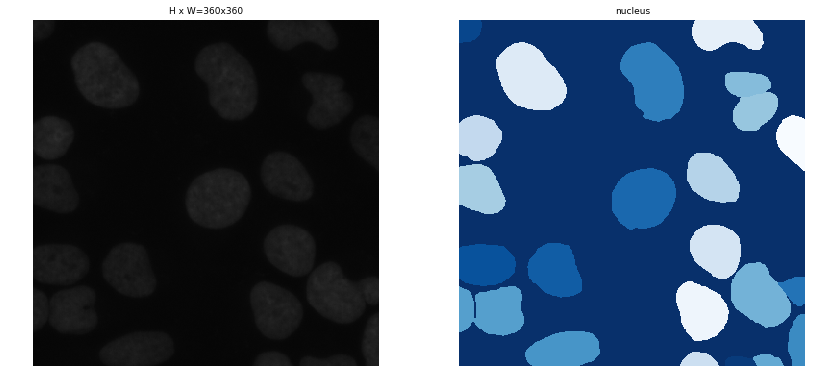

In [3]:
sys.path.append(ROOT_DIR)

dataset = nucleus.NucleusDataset()
dataset.load_nucleus(DATA_DIR, "demo")
dataset.prepare()

for image_id in dataset.image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

# Inference Configuration
config = nucleus.NucleusInferenceConfig()
# config.display()

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)


## Mask R-CNN results

In [ ]:
for image_id in dataset.image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)

    def display_top_masks(image, mask, class_ids, class_names, model, limit=4):
        """Display the given image and the top few class masks."""
        to_display = []
    #     titles = []
        to_display.append(image)
    #     titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
        # Pick top prominent classes in this image
        unique_class_ids = np.unique(class_ids)
        mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                     for i in unique_class_ids]
        top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                        key=lambda r: r[1], reverse=True) if v[1] > 0]
        # Generate images and titles
        for i in range(limit):
            class_id = top_ids[i] if i < len(top_ids) else -1
            # Pull masks of instances belonging to the same class.
            m = mask[:, :, np.where(class_ids == class_id)[0]]
            m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
            to_display.append(m)
    #         titles.append(class_names[class_id] if class_id != -1 else "-")

        titles = ["original image", "actual mask"]
        for weights in ["aug_0", "aug_1", "aug_2", "aug_3", "aug_4"]:
            weights_path = os.path.join(MCRNN_WEIGHTS, "mrcnn_"+weights+".h5")
            model.load_weights(weights_path, by_name=True)
            results = model.detect([image], verbose=0)[0]
            masks = np.sum(results["masks"] * np.arange(1, results["masks"].shape[-1] + 1), -1)
            to_display.append(masks)
            titles.append(weights+" predicted mask")
        display_images(to_display, titles=titles, cols=7, cmap="Blues_r")

    display_top_masks(image, mask, class_ids, dataset.class_names, model, limit=1)

## U-net results

In [ ]:
for image_id in dataset.image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)

    def display_top_masks(image, mask, class_ids, class_names, model, limit=4):
        """Display the given image and the top few class masks."""
        to_display = []
    #     titles = []
        to_display.append(image)
    #     titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
        # Pick top prominent classes in this image
        unique_class_ids = np.unique(class_ids)
        mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                     for i in unique_class_ids]
        top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                        key=lambda r: r[1], reverse=True) if v[1] > 0]
        # Generate images and titles
        for i in range(limit):
            class_id = top_ids[i] if i < len(top_ids) else -1
            # Pull masks of instances belonging to the same class.
            m = mask[:, :, np.where(class_ids == class_id)[0]]
            m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
            to_display.append(m)
    #         titles.append(class_names[class_id] if class_id != -1 else "-")
        img = resize(image, (128, 128), mode='constant', preserve_range=True)
        titles = ["original image", "actual mask"]
        for weights in ["aug_0", "aug_1", "aug_2", "aug_3", "aug_4"]:
            weights_path = os.path.join(UNET_WEIGHTS, "unet_"+weights+".h5")
            mod = load_model(weights_path, custom_objects={'mean_iou': mean_iou})
            mod._make_predict_function()
            preds_test = mod.predict(np.expand_dims(img, axis=0))
            preds_test_t = (preds_test > 0.5).astype(np.uint8)
            preds_test_upsampled = []
            for i in range(len(preds_test)):
                preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                                   (image.shape[0], image.shape[1]),
                                                   mode='constant', preserve_range=True))
            masks = np.sum(preds_test_upsampled[0] * np.arange(1, preds_test_upsampled[0].shape[-1] + 1), -1)
            to_display.append(masks)
            titles.append(weights+" predicted mask")
        display_images(to_display, titles=titles, cols=7, cmap="Blues_r")

    display_top_masks(image, mask, class_ids, dataset.class_names, model, limit=1)